In [1]:
push!(LOAD_PATH, "/theory/clau/PBJ/src/base/")

#> PBJ Modules
using ParticlesModule
using GridModule
using ParticleGridInteractionModule
using UnitsModule
using FieldModule

#> Julia Plotting Modules
using Plots
using Plots.PlotMeasures

#> Extendable arrays module
using ElasticArrays

#> LaTeX
using LaTeXStrings

ENV["GKS_ENCODING"]="utf-8"

#> FileIO Module
#using HDF5,JLD

"utf-8"

In [2]:
#> Number of snapshots made
N_snapshot_steps = 100
#> Number of steps made
N_steps = 1000
#> Number of skips for gif making
N_skip = Int(round(N_steps/N_snapshot_steps))


10

In [3]:
temperature = 2.2
density = 5.0e13
units=UnitsModule.SetUnits(density,temperature)
println("Normalized Epsilon0:",units.norm_permittivity)
println("Unit Length:",units.unit_length)
println("Unit Velocity:",units.unit_velocity)
println("Unit Time:",units.unit_time)

Normalized Epsilon0:189554.76269104556
Unit Length:0.001559270869791819
Unit Velocity:622011.0478385943
Unit Time:2.50682182448379e-9


# Physical Considerations

Given a supersonic electron drift-velocity ($v_{beam}>\sqrt{T_e/m_e}$), a two stream instability can arise. The two stream instability would expect the mode of largest growth to match the condition of

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\vec{k}\cdot \vec{v}_{beam} - \omega_{p,e} = 0$.

For the dimensionless equations of PBJ, this means that if we want this mode to be the fundamental (longest wavelength) mode,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k = \omega_{p,e}/ v_{beam}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $2\pi/L = \omega_{p,e}/ v_{beam}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $L \to v_{beam}*2\pi/\omega_{p,e} $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{L} \to \hat{v}_{beam}*2\pi $

since $\omega_{p,e}\to 1$ and velocities are normalized by the equilibrium thermal velocity. 

For this fastest growing mode, the frequency is expected to be 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\omega/\omega_{p,e}\equiv\frac{1}{2}\left(\frac{m_e}{m_i}\right)^{1/3}$

with growth-rate

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\gamma/\omega_{p,e}\equiv\frac{\sqrt{3}}{2}\left(\frac{m_e}{2 m_i}\right)^{1/3}$

In [4]:
#> Normalized simulation parameters

#> Beam velocity relative to thermal velocity
v_beam = 0.25

#> Number of vortices
N_swirlies = 3

#> [grid cells]
N_x = 100*N_swirlies

#> Particles per cell
electron_ppc = 100
ion_ppc = 100

#> [electron mass]
ion_mass = 1836.0
ion_mass = 100.0
electron_mass = 1.0

#> [electron charge]
ion_charge = 1.0
electron_charge = -1.0

#> Expected frequency
omega_theory = 0.5*((electron_mass/ion_mass)^(1.0/3.0))
gamma_theory = sqrt(3.0)*0.5*((0.5*electron_mass/ion_mass)^(1.0/3.0))
dt = (1.0/omega_theory)*0.01
println(L"\omega     : ",omega_theory)
println(L"\gamma     : ",gamma_theory)
println(L"dt*\omega : ",dt*omega_theory)
println(L"dt*\gamma : ",dt*gamma_theory)
println("dt*N_t*gamma      : ",dt*N_steps*gamma_theory)

#> Beam velocity divided by 2pi \omega_pe
L_x = v_beam*(2.0*pi)*float(N_swirlies)

#> [m]
dx = L_x/N_x

#> Injection zone buffer fraction
injection_zone_buffer_fraction = 0.01

#> Relative to eq. temperature
ion_temperature = 1.0*((v_beam*(electron_mass/ion_mass)*0.1)^2)
electron_temperature = 1.0*((v_beam*0.1)^2)

#> Normalized
ion_thermal_velocity = UnitsModule.GetThermalVelocity(
    ion_temperature*units.unit_temperature,ion_mass*units.unit_mass
)/units.unit_velocity
electron_thermal_velocity = UnitsModule.GetThermalVelocity(
    electron_temperature*units.unit_temperature,electron_mass*units.unit_mass
)/units.unit_velocity

#> Relative to unit density
ion_density = 1.0
electron_density = 1.0

$\omega     : $0.1077217345015942
$\gamma     : $0.14808826096823643
$dt*\omega : $0.01
$dt*\gamma : $0.013747296369986027
dt*N_t*gamma      : 13.747296369986026


1.0

In [5]:
#> Normalize to simulation units
struct Parameters
    dt :: Float64
    dx :: Float64
    L_x :: Float64
    N_x :: Int
    #> ion species
    ion_ppc :: Int
    ion_temperature :: Float64
    ion_density :: Float64
    ion_mass :: Float64
    ion_charge :: Float64
    ion_thermal_velocity :: Float64
    ion_particle_shape_x :: Float64
    #> electron species
    electron_ppc :: Int
    electron_temperature :: Float64
    electron_density :: Float64
    electron_mass :: Float64
    electron_charge :: Float64
    electron_thermal_velocity :: Float64
    electron_particle_shape_x :: Float64
    #> miscellany
    v_beam :: Float64
#     phi_left_boundary :: Float64
#     phi_right_boundary :: Float64
#     injection_zone_buffer_fraction :: Float64
end

Simulation_Parameters=Parameters(
    dt,
    dx,
    L_x,
    N_x,
    ion_ppc,
    ion_temperature,
    ion_density,
    ion_mass,
    ion_charge,
    ion_thermal_velocity,
    dx*0.5,
    
    electron_ppc,
    electron_temperature,
    electron_density,
    electron_mass,
    electron_charge,
    electron_thermal_velocity,
    dx*0.5,
    
    v_beam
#     phi_left_boundary/units.unit_potential,
#     phi_right_boundary/units.unit_potential,
#     injection_zone_buffer_fraction
)

function Initialize(sim_params)
    #> Initialize the mesh
    grid=GridModule.GridArrayInit(
        sim_params.N_x+1,0.0,sim_params.L_x,
        5,0.0,1.0,
        5,0.0,1.0
    )
    vlim=3
    vgrid=GridModule.GridArrayInit(
        101,-vlim,vlim,
        5,-vlim,vlim,
        5,-vlim,vlim,
    )
    #> Initialize the particles
    electrons=ParticlesModule.ParticleArrayOrderedInit(
        number_particles=sim_params.electron_ppc*sim_params.N_x,
        mass=sim_params.electron_mass,
        charge=sim_params.electron_charge,
        x_length=maximum(grid.x),y_length=maximum(grid.y),z_length=maximum(grid.z),
        vx_thermal_speed=sim_params.electron_thermal_velocity,
        vy_thermal_speed=0.0,vz_thermal_speed=0.0,
        particle_shape_x=sim_params.electron_particle_shape_x,
        time_step=sim_params.dt
    );
    N_physical = sim_params.electron_density * sim_params.L_x
    N_markers = length(electrons.particle)
    for ip in 1:length(electrons.particle)
       electrons.particle[ip].f_over_g = N_physical/N_markers 
    end
    ParticlesModule.AddParticleDrift_x!(
        electrons,sim_params.v_beam
    )
    ParticlesModule.AddParticleRandomPositionPerturbation_x!(
        electrons,sim_params.electron_particle_shape_x
    )
    ions=ParticlesModule.ParticleArrayOrderedInit(
        number_particles=sim_params.ion_ppc*sim_params.N_x,
        mass=sim_params.ion_mass,
        charge=sim_params.ion_charge,
        x_length=maximum(grid.x),y_length=maximum(grid.y),z_length=maximum(grid.z),
        vx_thermal_speed=sim_params.ion_thermal_velocity,
        vy_thermal_speed=0.0,vz_thermal_speed=0.0,
        particle_shape_x=sim_params.ion_particle_shape_x,
        time_step=sim_params.dt
    );
    ParticlesModule.AddParticleRandomPositionPerturbation_x!(
        ions,sim_params.ion_particle_shape_x
    )
    N_physical = sim_params.ion_density * sim_params.L_x
    N_markers = length(ions.particle)
    for ip in 1:length(ions.particle)
       ions.particle[ip].f_over_g = N_physical/N_markers 
    end
    
    #> Initialize the Fields struct
    Fields_struct=FieldModule.Fields_Init(grid)

    return grid,vgrid,Fields_struct,ions,electrons
end
grid,vgrid,Fields_struct,ions,electrons=Initialize(Simulation_Parameters)

avg_field_struct=FieldModule.Fields_Init(grid)

println("N_e,0:",electrons.number_particles)
println("N_i,0:",ions.number_particles)

println("dt:",dt)
println("dx:",dx)
println("L_x:",L_x)
println("ne:",electron_density)
println("ni:",ion_density)
println("v_the:",electron_thermal_velocity)
println("v_thi:",ion_thermal_velocity)

N_e,0:30000
N_i,0:30000
dt:0.09283177667225558
dx:0.015707963267948967
L_x:4.71238898038469
ne:1.0
ni:1.0
v_the:0.025000000000000005
v_thi:2.5e-5


N_electrons:30000
N_ions:30000


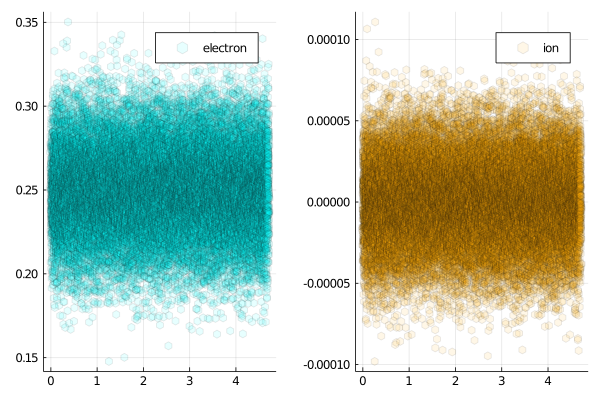

In [6]:
pe_x = fill(0.0,electrons.number_particles)
pe_vx = fill(0.0,electrons.number_particles)
pe_f_over_g = fill(0.0,electrons.number_particles)

for ip in 1:electrons.number_particles
    pe_x[ip]=electrons.particle[ip].x
    pe_vx[ip]=electrons.particle[ip].vx
    pe_f_over_g[ip]=electrons.particle[ip].f_over_g
end

pi_x = fill(0.0,ions.number_particles)
pi_vx = fill(0.0,ions.number_particles)
pi_f_over_g = fill(0.0,ions.number_particles)

for ip in 1:ions.number_particles
    pi_x[ip]=ions.particle[ip].x
    pi_vx[ip]=ions.particle[ip].vx
    pi_f_over_g[ip]=ions.particle[ip].f_over_g
end
println("N_electrons:",electrons.number_particles)
println("N_ions:",ions.number_particles)

    
#> For plotting:
xlim_delta = 0.1*(maximum(grid.x)-minimum(grid.x))
xlim_min = (minimum(grid.x)-xlim_delta)*units.unit_length*1e2
xlim_max = (maximum(grid.x)-xlim_delta)*units.unit_length*1e2
alpha_i = min(1.0,1.0/log(ions.number_particles))
alpha_e = min(1.0,1.0/log(electrons.number_particles))

plot(
    scatter(
        pe_x,pe_vx,
        marker=:hexagon,
        color=:cyan,
        label="electron",
        alpha=alpha_e
    ),
    scatter(
        pi_x,pi_vx,
        marker=:hexagon,
        color=:orange,
        label="ion",
        alpha=alpha_i

    ),
    fmt=:png,
    layout=(1,2)
)

In [7]:
function Calculate_Electrostatic_Potential(
        fields_struct,
        ions,electrons,grid,
        sim_params,
        units
    )
    #> Scatter ions to grid
    ion_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(
        ions,grid
    );
    #> Apply periodic boundary conditions and smooth
    FieldModule.ApplyPeriodicBoundary!(ion_density);    
    ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x_121_periodic(
        2,ion_density,ions,grid
    );
    
    #> Divide by the cell size to get density. The ends are duplicates of eac hother.
    ion_density ./= grid.x[2]-grid.x[1]
    
    #> Scatter electrons to grid
    electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(
        electrons,grid
    );
    #> Apply periodic boundary conditions and smooth
    FieldModule.ApplyPeriodicBoundary!(electron_density);    
    electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x_121_periodic(
        2,electron_density,electrons,grid
    );
    #> Divide by the cell size to get density. The ends are duplicates of eac hother.
    electron_density ./= grid.x[2]-grid.x[1]
    
    phi=FieldModule.Poisson_1D_Solve_Periodic(
        (ion_density.-electron_density),
        grid
    );
    fields_struct.phi[1:end]=phi[1:end]
    fields_struct.electron_density[1:end]=electron_density[1:end]
    fields_struct.ion_density[1:end]=ion_density[1:end]
end

function Inject_Particles!(ions,electrons,sim_params)
        #> Inject new particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            electrons,grid,sim_params.electron_density,
            particles_per_cell=sim_params.electron_ppc,
            vx_thermal_speed=sim_params.electron_thermal_velocity,
            vy_thermal_speed=sim_params.electron_thermal_velocity,
            vz_thermal_speed=sim_params.electron_thermal_velocity,
            time_step=sim_params.dt,
            buffer_fraction=sim_params.injection_zone_buffer_fraction,
            buffer_multiplier=20
        );
        
        #> Inject new particles
        ParticlesModule.ParticleInjectionFromLeft_Continue!(
            ions,grid,sim_params.ion_density,
            particles_per_cell=sim_params.ion_ppc,
            vx_thermal_speed=sim_params.ion_thermal_velocity,
            vy_thermal_speed=sim_params.ion_thermal_velocity,
            vz_thermal_speed=sim_params.ion_thermal_velocity,
            time_step=sim_params.dt,
            buffer_fraction=sim_params.injection_zone_buffer_fraction,
            buffer_multiplier=200
        );
end

function Field_to_Particles!(fields_struct,ions,electrons,grid)
    #> Calculate the electric field from electrostatic potential
    electric_field_x = FieldModule.CalculateElectricField_FD_1D_periodic(
        fields_struct.phi,grid
    )
#     electric_field_x = FieldModule.CalculateElectricField_FFT_1D(
#         fields_struct.phi,grid
#     )
    #> Scatter field to particles
    ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
        electric_field_x,electrons,grid
    )         
    ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
        electric_field_x,ions,grid
    )         
end

function Push_Particles!(ions,electrons,grid,sim_params)
    #> Push particles
    ParticlesModule.UpdateParticlePosition!(electrons)
    ParticlesModule.UpdateParticleVelocity!(electrons)
    ParticlesModule.UpdateParticlePosition!(ions)
    ParticlesModule.UpdateParticleVelocity!(ions)
    #> Apply the left/right hand side PERIODIC boundary
    ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(
        electrons,
        grid
    )
    ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(
        ions,
        grid
    )
end


Push_Particles! (generic function with 1 method)

In [8]:
#> Initial calculation step

Calculate_Electrostatic_Potential(
    Fields_struct,ions,electrons,grid,Simulation_Parameters,units
    );
phi0=copy(Fields_struct.phi)
avg_field_struct.phi[:] = Fields_struct.phi[:]
avg_field_struct.ion_density[:] = Fields_struct.ion_density[:]
avg_field_struct.electron_density[:] = Fields_struct.electron_density[:]
Field_to_Particles!(Fields_struct,ions,electrons,grid)
Push_Particles!(ions,electrons,grid,Simulation_Parameters)

potential_all=ElasticArray{Float64}(undef, length(Fields_struct.phi), 0);
append!(potential_all, Fields_struct.phi);

time_all=[electrons.particle[1].dt]

ParticlesModule.UpdateParticleKineticEnergy!(electrons)
electron_energy_all=[electrons.total_kinetic_energy]
ParticlesModule.UpdateParticleKineticEnergy!(ions)
ion_energy_all=[ions.total_kinetic_energy]

1-element Array{Float64,1}:
 1.4786874505504996e-7

In [9]:
function plot_summary(
        i,phi0,
        grid,sim_params,units,
        Fields_struct,electrons,ions,   
        avg_field_struct;
        plot_fmt=:svg
    )
    #> Get the phase space arrays
    pe_x = fill(0.0,electrons.number_particles)
    pe_vx = fill(0.0,electrons.number_particles)
    #pe_f_over_g = fill(0.0,electrons.number_particles)
    for ip in 1:electrons.number_particles
        pe_x[ip]=electrons.particle[ip].x
        pe_vx[ip]=electrons.particle[ip].vx
        #pe_f_over_g[ip]=electrons.particle[ip].f_over_g
    end
    pi_x = fill(0.0,ions.number_particles)
    pi_vx = fill(0.0,ions.number_particles)
    #pi_f_over_g = fill(0.0,ions.number_particles)
    for ip in 1:ions.number_particles
        pi_x[ip]=ions.particle[ip].x
        pi_vx[ip]=ions.particle[ip].vx
        #pi_f_over_g[ip]=ions.particle[ip].f_over_g
    end
    
    #> For plotting:
    xlim_delta = 0.1*(maximum(grid.x)-minimum(grid.x))
    xlim_min = (minimum(grid.x)-xlim_delta)*units.unit_length*1e2
    xlim_max = (maximum(grid.x)+xlim_delta)*units.unit_length*1e2
    alpha_i = min(1.0,1.0/log(ions.number_particles))
    alpha_e = min(1.0,1.0/log(electrons.number_particles))
    
    past_frac = 0.999
    pres_frac = 1.0-past_frac
    avg_field_struct.phi[:] = (
        (avg_field_struct.phi[:]*past_frac)
        +(Fields_struct.phi[:]*pres_frac)
    )
    avg_field_struct.ion_density[:] = (
        (avg_field_struct.ion_density[:]*past_frac)
        +(Fields_struct.ion_density[:]*pres_frac)
    )
    avg_field_struct.electron_density[:] = (
        (avg_field_struct.electron_density[:]*past_frac)
        +(Fields_struct.electron_density[:]*pres_frac)
    )
    
    plot(
        plot(
            grid.x*units.unit_length*1e2,Fields_struct.phi,
            label="t="*string(
               round(i*sim_params.dt*units.unit_time*1e6,sigdigits=3)
               )*"[mu s]",
            linestyle=:dash
        ),
        plot(
            grid.x*units.unit_length*1e2,Fields_struct.ion_density,
            color=:orange,
            label="N_i="*string(ions.number_particles),
        ),
        scatter(
            pi_x*units.unit_length*1e2,
            pi_vx,#*sim_params.ion_mass,
            marker=:hexagon,
            color=:orange,
            markersize=2,
            alpha=alpha_i
        ),
        fmt = plot_fmt,
        layout=(1,3),
        size=(1800,400)
    )
    
    #> SP 1: potential
    plot!(
        sp=1,
        #ylims=(-1,7.5), 
        xlims=(
            xlim_min,xlim_max
        ), 
        frame=:zerolines,
        ylabel="phi (e phi/T_e0)", xlabel="x[cm]",
        legend=(0.8,0.8),
        foreground_color_legend = nothing,
        margin=20px
    )

    #> SP 2: densities
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,Fields_struct.electron_density,
        color=:darkcyan,
        label="N_e="*string(electrons.number_particles),
    )
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,avg_field_struct.ion_density,
        linestyle=:dash,
        color=:orange,
        label="N_i(avg)"
    )
    plot!(
        sp=2,
        grid.x*units.unit_length*1e2,avg_field_struct.electron_density,
        linestyle=:dash,
        color=:darkcyan,
        label="N_e(avg)",
    )
    plot!(
        sp=2,
        ylims=(-0.1,3.1), 
        xlims=(
            xlim_min,xlim_max 
        ), 
        frame=:zerolines,
        ylabel="densities (n_j/n_0)", xlabel="x[cm]",
        legend=(0.8,0.8),
        foreground_color_legend = nothing,
        margin=20px
    )
    
    #> SP 3: phase space
    scatter!(
        sp=3,
        pe_x*units.unit_length*1e2,
        pe_vx,#*sim_params.electron_mass,
        marker=:hexagon,
        color=:darkcyan,
        markersize=2,
        alpha=alpha_e
    )
    plot!(
        sp=3,
        ylims=(-sim_params.v_beam*sim_params.electron_mass*5.0,sim_params.v_beam*sim_params.electron_mass*5.0), 
        xlims=(
            xlim_min,xlim_max
        ), 
        frame=:zerolines,
        ylabel="vx", xlabel="x[cm]",
        legend=false,
        #foreground_color_legend = nothing,
        margin=20px
    )
end

plot_summary (generic function with 1 method)

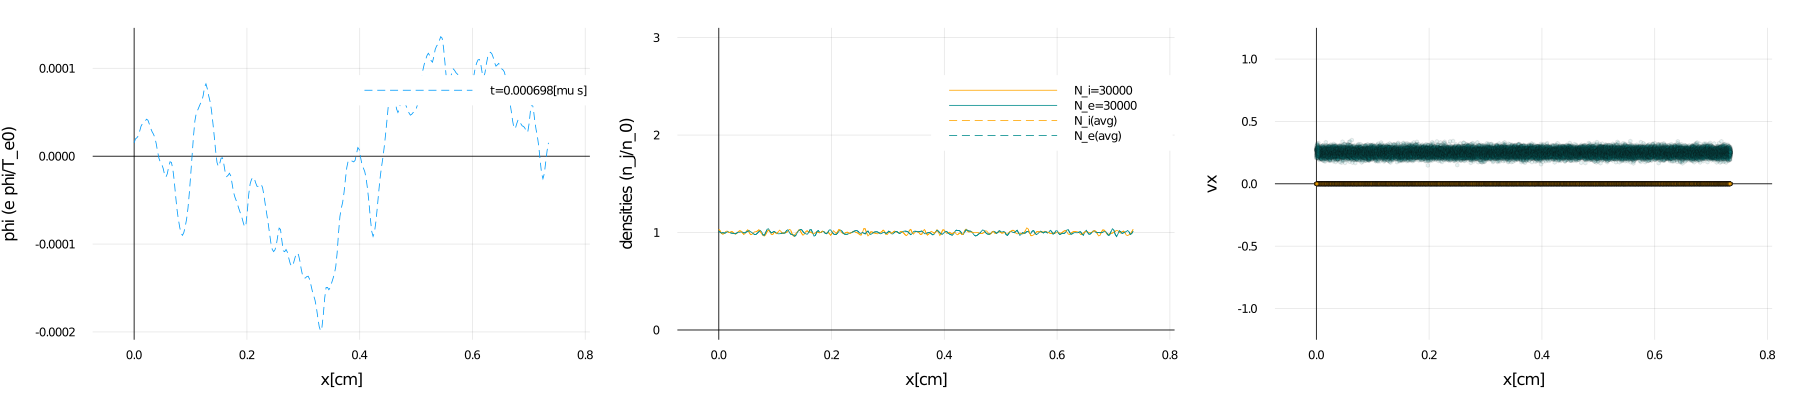

In [10]:
plot_summary(
        3,phi0,
        grid,Simulation_Parameters,units,
        Fields_struct,electrons,ions,  
        avg_field_struct,
        plot_fmt=:png
    )

In [11]:
if(true)
    anim = @animate for i in 1:N_steps
#         #> Inject new particles
#         Ne_current=electrons.number_particles
#         Ni_current=ions.number_particles
#         Inject_Particles!(ions,electrons,Simulation_Parameters)
#         Ne_post_injection=electrons.number_particles
#         Ni_post_injection=ions.number_particles
    
        #> Calculaute potential
        Calculate_Electrostatic_Potential(
            Fields_struct,ions,electrons,grid,Simulation_Parameters,units
            );
        
        #> Calculuate fields on particles
        Field_to_Particles!(Fields_struct,ions,electrons,grid)
        
        #> Push particles
        Push_Particles!(ions,electrons,grid,Simulation_Parameters)

        append!(potential_all, Fields_struct.phi);
        append!(time_all,time_all[end]+electrons.particle[1].dt)

#         Ne_post_absorption=electrons.number_particles
#         Ni_post_absorption=ions.number_particles

#         append!(Ne_markers,[electrons.number_particles])
#         append!(Ne_array,[length(electrons.particle)])
#         append!(Ne_injected,[Ne_post_injection-Ne_current])
#         append!(Ne_absorbed,[Ne_post_absorption-Ne_post_injection])
#         append!(Ne_changed,[Ne_post_absorption-Ne_current])

#         append!(Ni_markers,[ions.number_particles])
#         append!(Ni_array,[length(ions.particle)])
#         append!(Ni_injected,[Ni_post_injection-Ni_current])
#         append!(Ni_absorbed,[Ni_post_absorption-Ni_post_injection])
#         append!(Ni_changed,[Ni_post_absorption-Ni_current])
#
#        append!(i_step,[i])
        plot_summary(
            i,phi0,
            grid,Simulation_Parameters,units,
            Fields_struct,electrons,ions, 
            avg_field_struct
        )
        end every N_skip
end;

┌ Info: Saved animation to 
│   fn = /theory/clau/PBJ/src/base/two-stream_fps=100.gif
└ @ Plots /theory/clau/.julia/packages/Plots/XJg0n/src/animation.jl:102


Plots.AnimatedGif("/theory/clau/PBJ/src/base/two-stream_fps=100.gif")
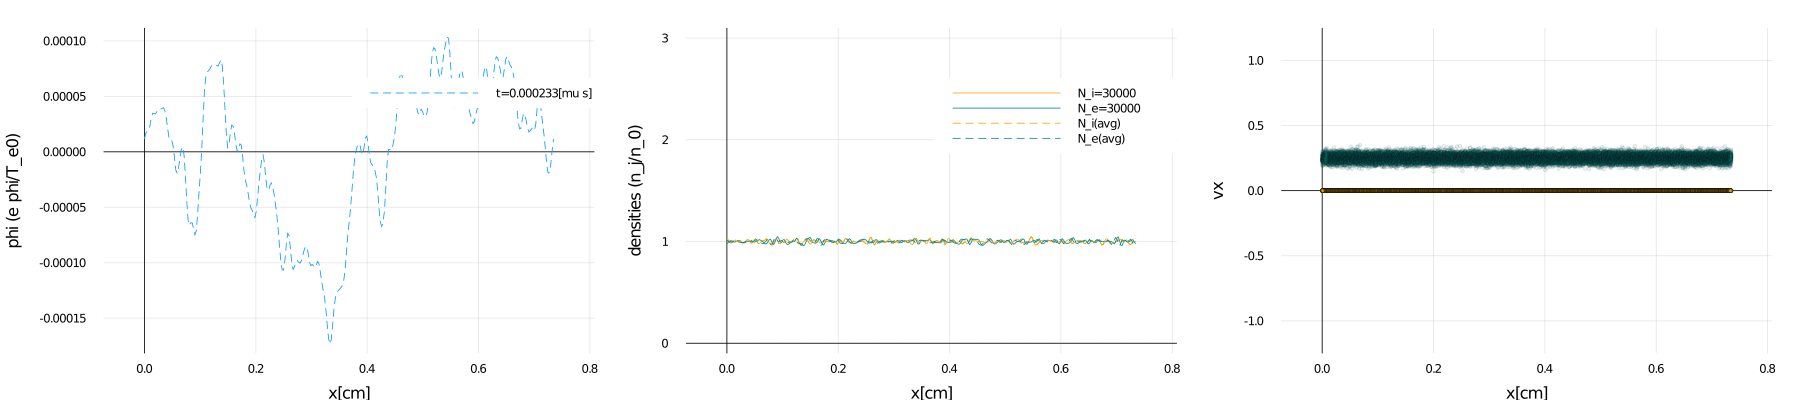

In [12]:
if(true)
    fps=100
    gif(anim, "two-stream_fps="*string(fps)*".gif", fps = fps)
end

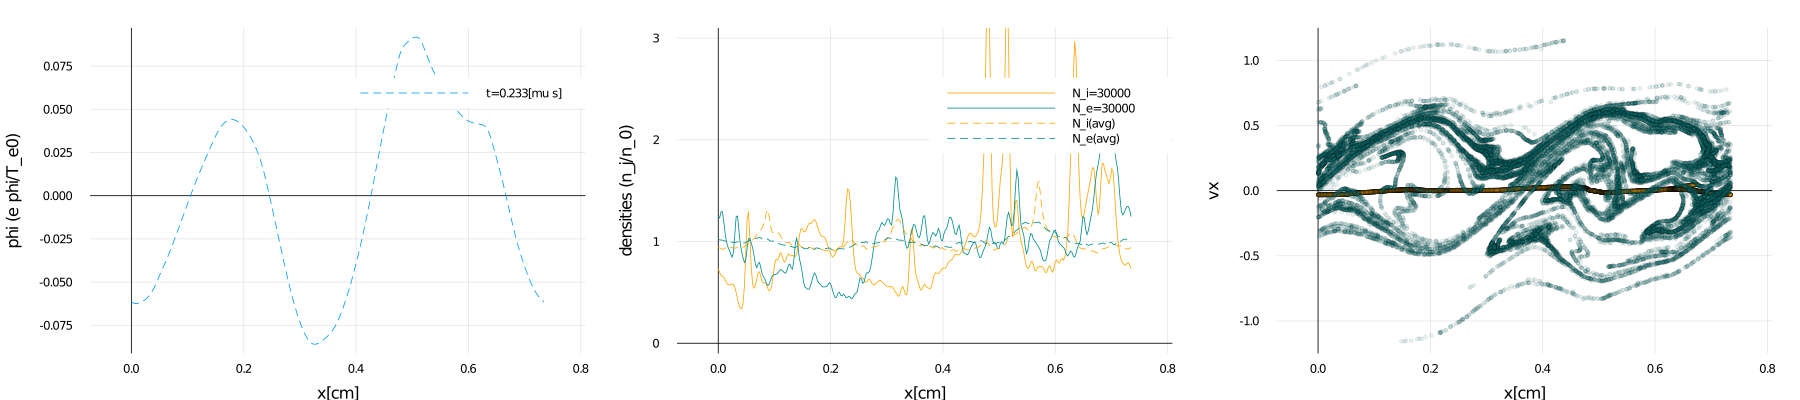

In [13]:
plot_summary(
        N_steps,phi0,
        grid,Simulation_Parameters,units,
        Fields_struct,electrons,ions,  
        avg_field_struct,
        plot_fmt=:png
    )

In [14]:
using FFTW

In [27]:
m_mode = 3
potential_fft = fill(0.0+0.0im,size(potential_all)[2])
for i in 1:length(potential_fft)
    potential_fft[i]=FFTW.rfft(potential_all[1:end,i])[1+m_mode]
end
plot(
    layout=(2,1),
    size=(900,600),
    #fmt=:png
)
plot!(
    sp=1,
    time_all,
    real(potential_fft),
    label="real",
    color=:darkcyan,
    linestyle=:solid
)
plot!(
    sp=1,
    time_all,
    imag(potential_fft),
    label="imag",
    color=:orange,
    linestyle=:dash
)
plot!(
    sp=1,
    ylabel="e*phi/Te0",
    xlabel="t omega_pe",
    legend=(0.2,0.3)
)

plot!(
    sp=2,
    time_all,
    abs.(potential_fft),
    label="simulation",
    yscale=:log
)

plot!(
    sp=2,
    time_all,
    exp.(gamma_theory*time_all)*abs(potential_fft[1])*0.5,
    label="theory",
    linestyle=:dash,
    yscale=:log
)
plot!(
    sp=2,
    ylims=(1e-4,2e1),
    ylabel="e*|phi|/Te0",
    xlabel="t omega_pe",
    legend=(0.8,0.3)
)

savefig("/theory/clau/PBJ/figures/two-stream_instability.png")

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /theory/clau/.julia/packages/Plots/XJg0n/src/args.jl:1162
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /theory/clau/.julia/packages/Plots/XJg0n/src/args.jl:1162
